乳胶枕lstm尝试预测  
## 方案1 不划分周期，直接对过去长序预测

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


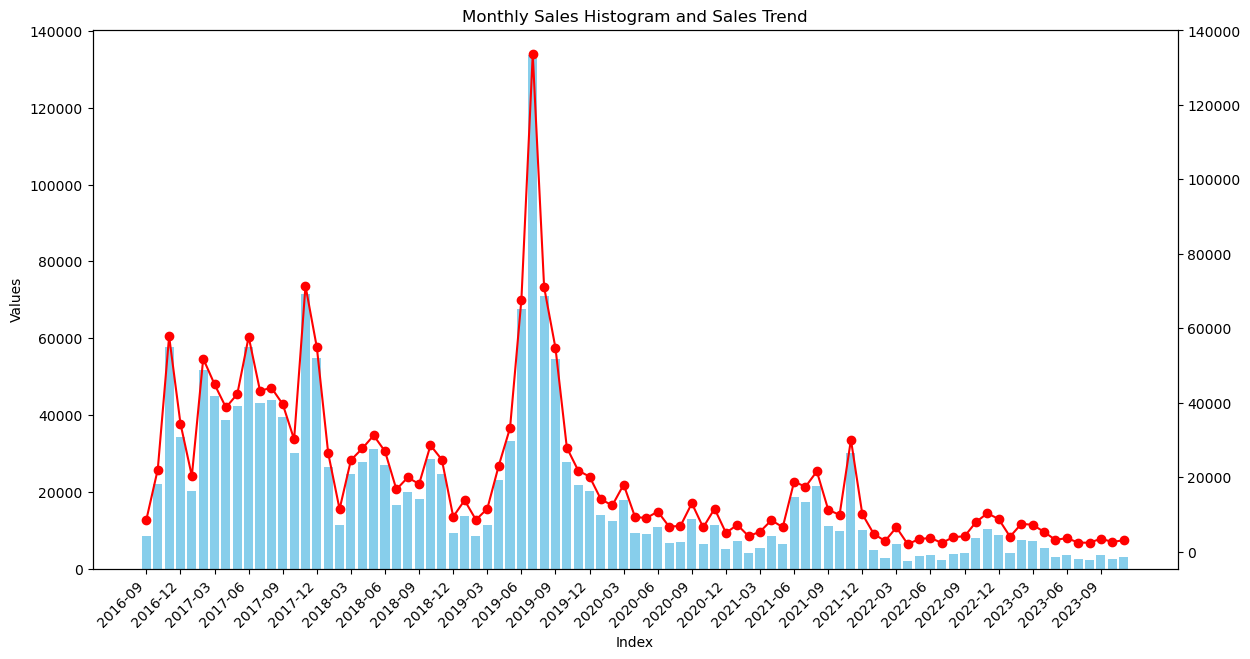

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_excel('产品数据.xlsx', sheet_name = 'Sheet1')
df1 = df1.dropna()
df1 = df1[df1['Month']<=12]
sales = df1['Sales_volumn'].to_list()
dates = pd.date_range(start='2016-09', end='2023-12', freq='M').strftime('%Y-%m')



# 创建图形对象
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制柱状图

ax1.bar(dates, sales, color='skyblue')
ax1.set_title('Monthly Sales Histogram and Sales Trend')
ax1.set_xlabel('Index')
ax1.set_ylabel('Values')

# 每三个月显示一个日期
xticks_positions = range(0, len(dates), 3)
xticks_labels = [dates[i] for i in xticks_positions]
ax1.set_xticks(xticks_positions)
ax1.set_xticklabels(xticks_labels, rotation=45, ha='right')

ax2 = ax1.twinx()
  
# 绘制曲线图
ax2.plot(dates, sales, marker='o', color='red')


plt.show()

In [3]:
df1 = df1.rename(columns = {' Cost ': 'Cost'})
df1['Unit_cost'] = df1['Cost']/df1['Sales_volumn']
df1['ROI'] = df1['Profit'] / (df1['Cost'] + df1['Promotion_expense'])
df1['Profit_rate'] = df1['Profit']/df1['Revenue']
df1['Target'] = df1['Sales_volumn'].shift(-1)
df1

,Month,Unit_price,Sales_volumn,Revenue,Cost,Promotion_expense,Profit,Unit_cost,ROI,Profit_rate,Target
1,9,231.022793,8599.0,1986565.00,513463.73,2.979848e+05,1.175117e+06,59.712028,1.448171,0.591532,22031.0
2,10,228.190640,22031.0,5027268.00,1296847.55,7.540902e+05,2.976330e+06,58.864670,1.451205,0.592037,57819.0
3,11,235.609903,57819.0,13622729.00,3466877.14,2.043409e+06,8.112443e+06,59.960863,1.472236,0.595508,34354.0
4,12,232.228445,34354.0,7977976.00,2038590.83,1.196696e+06,4.742689e+06,59.340712,1.465925,0.594473,20282.0
6,1,101.821270,20282.0,2065139.00,1170602.10,3.097708e+05,5.847661e+05,57.716305,0.395013,0.283161,51821.0
...,...,...,...,...,...,...,...,...,...,...,...
90,7,92.408766,2407.0,222427.90,119451.71,3.336418e+04,6.961201e+04,49.626801,0.455529,0.312964,2368.0
91,8,99.675908,2368.0,236032.55,130987.47,3.540488e+04,6.964020e+04,55.315655,0.418530,0.295045,3459.0
92,9,91.487771,3459.0,316456.20,164136.12,4.746843e+04,1.048516e+05,47.451899,0.495508,0.331331,2572.0
93,10,98.970560,2572.0,254552.28,128578.71,3.818284e+04,8.779073e+04,49.991722,0.526445,0.344883,3046.0


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 数据准备
# 假设 df 是你的 DataFrame，包含 'cost', 'price', 'ad_spend', 'ROI', 'sales', 'month' 列和 'next_month_sales' 列
# df = pd.DataFrame(...)  # 使用你的实际数据

# 提取特征和目标变量
features = ['Month', 'Sales_volumn','Unit_price', 'Promotion_expense',  'ROI', 'Profit_rate', 'Unit_cost',]
target = 'Target'

# 特征归一化处理
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df1[features])

# 销量归一化处理
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(df1[[target]])

# 转换为 PyTorch 张量
X = torch.tensor(X, dtype=torch.float32, requires_grad = True)
y = torch.tensor(y, dtype=torch.float32, requires_grad = True)

# 计算每个月份的历史均值
monthly_averages = df1.groupby('Month')[features[2:]].mean()

X_train = X[:-1]
y_train = y[:-1]

In [32]:
# 2. 定义 LSTM 模型
class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)
        predictions = self.fc(lstm_out)
        return predictions, hidden

# 参数设定
input_size = len(features)  # 特征数量
hidden_size = 50  # 隐藏层的大小，你可以调整
output_size = 1
num_epochs = 100
learning_rate = 0.01

model = SalesLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # 损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [35]:
# 3. 训练模型
for epoch in range(num_epochs):
    hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))
    loss = 0.0
    for i in range(len(X_train)):
        x_input = X_train[i].view(1, 1, -1)  # 输入数据
        y_target = y_train[i].view(1, 1, -1)  # 目标值是下一个月的销量
        y_pred, hidden = model(x_input, hidden)
        loss =loss +  criterion(y_pred.view(-1), y_target.view(-1))
    loss = torch.mean(loss/X_train.shape[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0183
Epoch [20/100], Loss: 0.0125
Epoch [30/100], Loss: 0.0108
Epoch [40/100], Loss: 0.0099
Epoch [50/100], Loss: 0.0086
Epoch [60/100], Loss: 0.0086
Epoch [70/100], Loss: 0.0063
Epoch [80/100], Loss: 0.0046
Epoch [90/100], Loss: 0.0049
Epoch [100/100], Loss: 0.0036


D:\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\a

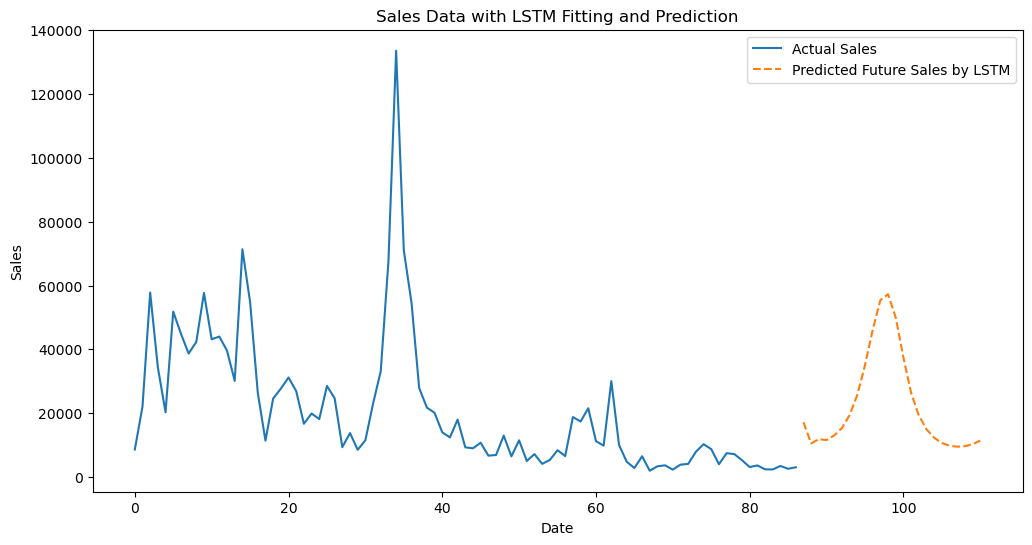

In [42]:
# 4. 预测未来销量
n_months = 24  # 预测未来12个月

# 获取最后一个月的特征作为基础
last_month_features = X[-1].view(1, 1, -1)

model.eval()  # 设置模型为评估模式
predicted_sales_normalized = []

with torch.no_grad():
    hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))

    # 预测第一个月的销量
    current_input = last_month_features

    # 预测第一个月的销量
    next_sales, hidden = model(current_input, hidden)
    predicted_sales_normalized.append(next_sales.item())
    
    # 预测第二个月及以后
    for i in range(1, n_months):
        # 提取当前月份
        current_month = int(current_input[0, 0, 0].item()) + 1
        if current_month > 12:
            current_month = 1
        
        # 获取历史中相同月份的平均值（不包括月份）
        month_mean_features = monthly_averages.loc[current_month].values

        # 更新输入的特征，保持月份自然递增，销量使用上个月预测的数据
        future_features = np.concatenate([
            np.array([current_month]),  # 月份特征
            [predicted_sales_normalized[-1]],  # 上个月的预测销量
            month_mean_features  # 其他特征
        ])

        # 对未来特征进行归一化
        normalized_future_features = scaler_X.transform([future_features])

        # 更新当前输入
        current_input = torch.tensor(normalized_future_features, dtype=torch.float32).view(1, 1, -1)

        # 预测下一个月的销量
        next_sales, hidden = model(current_input, hidden)
        
        # 保存预测结果
        predicted_sales_normalized.append(next_sales.item())

# 将归一化的预测结果转化为实际销量
predicted_sales_normalized = np.array(predicted_sales_normalized).reshape(-1, 1)
predicted_sales = scaler_y.inverse_transform(predicted_sales_normalized)

# 5. 绘制结果
plt.figure(figsize=(12, 6))

# 绘制历史实际销量
plt.plot(list(range(df1.shape[0])), df1['Sales_volumn'], label='Actual Sales')

# 绘制历史拟合销量
#plt.plot(df.index[1:], fitted_sales, label='Fitted Sales by LSTM', linestyle='--')

# 绘制未来预测销量
#future_dates = pd.date_range(start=df.index[-1], periods=n_months + 1, freq='M')[1:]
plt.plot(list(range(df1.shape[0],df1.shape[0]+n_months)), predicted_sales, label='Predicted Future Sales by LSTM', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data with LSTM Fitting and Prediction')
plt.legend()
plt.show()

长序训练对细节波动学习的不好，后期预测呈现了对称趋势，即无法进行过多预测

## 方案2 划分周期训练

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_excel('产品数据.xlsx', sheet_name = 'Sheet1')
df1 = df1.dropna()
df1 = df1[df1['Month']<=12]
df1 = df1.rename(columns = {' Cost ': 'Cost'})
df1['Unit_cost'] = df1['Cost']/df1['Sales_volumn']
df1['ROI'] = df1['Profit'] / (df1['Cost'] + df1['Promotion_expense'])
df1['Profit_rate'] = df1['Profit']/df1['Revenue']
df1['Target'] = df1['Sales_volumn'].shift(-1)
df1

,Month,Unit_price,Sales_volumn,Revenue,Cost,Promotion_expense,Profit,Version,Unit_cost,ROI,Profit_rate,Target
1,9,231.022793,8599.0,1986565.00,513463.73,2.979848e+05,1.175117e+06,1.0,59.712028,1.448171,0.591532,22031.0
2,10,228.190640,22031.0,5027268.00,1296847.55,7.540902e+05,2.976330e+06,1.0,58.864670,1.451205,0.592037,57819.0
3,11,235.609903,57819.0,13622729.00,3466877.14,2.043409e+06,8.112443e+06,1.0,59.960863,1.472236,0.595508,34354.0
4,12,232.228445,34354.0,7977976.00,2038590.83,1.196696e+06,4.742689e+06,1.0,59.340712,1.465925,0.594473,20282.0
6,1,101.821270,20282.0,2065139.00,1170602.10,3.097708e+05,5.847661e+05,1.0,57.716305,0.395013,0.283161,51821.0
...,...,...,...,...,...,...,...,...,...,...,...,...
90,7,92.408766,2407.0,222427.90,119451.71,3.336418e+04,6.961201e+04,4.0,49.626801,0.455529,0.312964,2368.0
91,8,99.675908,2368.0,236032.55,130987.47,3.540488e+04,6.964020e+04,4.0,55.315655,0.418530,0.295045,3459.0
92,9,91.487771,3459.0,316456.20,164136.12,4.746843e+04,1.048516e+05,4.0,47.451899,0.495508,0.331331,2572.0
93,10,98.970560,2572.0,254552.28,128578.71,3.818284e+04,8.779073e+04,4.0,49.991722,0.526445,0.344883,3046.0


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 假设 df1 是包含 'version' 列的 DataFrame
# df1 = pd.DataFrame(...)  # 使用你的实际数据

# 提取特征和目标变量
features = ['Month','Sales_volumn','Unit_price', 'Promotion_expense', 'ROI','Profit_rate','Unit_cost']
target = 'Target'

# 全局特征归一化处理
scaler_X = MinMaxScaler()
X_all = scaler_X.fit_transform(df1[features].values)

# 全局销量归一化处理
scaler_y = MinMaxScaler()
y_all = scaler_y.fit_transform(df1[[target]].values)

# 创建一个新的 DataFrame 副本来避免修改原始 DataFrame
col_range = ['Month','Sales_volumn','Unit_price', 'Promotion_expense', 'ROI','Profit_rate','Unit_cost', 'Target']
df1_normalized = df1[col_range].copy()
df1_normalized.loc[:, features] = X_all
df1_normalized.loc[:, target] = y_all
df1_normalized.loc[:, 'Version'] = df1['Version']

# 现在 df1_normalized 包含了所有归一化后的数据，并安全地更新了数据而不会引起警告
df1_normalized

,Month,Sales_volumn,Unit_price,Promotion_expense,ROI,Profit_rate,Unit_cost,Target,Version
1,0.727273,0.050381,0.973270,0.131649,0.980080,0.989714,0.986858,0.152418,1.0
2,0.818182,0.152418,0.956766,0.358562,0.982591,0.991021,0.942107,0.424285,1.0
3,0.909091,0.424285,1.000000,1.000000,1.000000,1.000000,1.000000,0.246031,1.0
4,1.000000,0.246031,0.980296,0.578759,0.994776,0.997322,0.967248,0.139132,1.0
6,0.000000,0.139132,0.220385,0.137513,0.108295,0.191920,0.881458,0.378720,1.0
...,...,...,...,...,...,...,...,...,...
90,0.545455,0.003342,0.165537,0.000000,0.158389,0.269026,0.454225,0.003046,4.0
91,0.636364,0.003046,0.207884,0.001015,0.127762,0.222666,0.754672,0.011334,4.0
92,0.727273,0.011334,0.160170,0.007017,0.191483,0.316542,0.339362,0.004596,4.0
93,0.818182,0.004596,0.203774,0.002397,0.217092,0.351603,0.473498,0.008197,4.0


In [59]:
# 按照版本切割数据
version_groups = df1_normalized.iloc[:-1, :].groupby('Version')

# 为每个版本的数据创建 DataLoader
dataloaders = []

for version, group in version_groups:
    X = torch.tensor(group[features].values, dtype=torch.float32)
    y = torch.tensor(group[target].values, dtype=torch.float32).view(-1)
    
    # 创建 TensorDataset 并整合为 DataLoader
    dataset = (X, y)
    
    # 存储 DataLoader
    dataloaders.append(dataset) 

In [60]:
dataloaders[0]

(tensor([[0.7273, 0.0504, 0.9733, 0.1316, 0.9801, 0.9897, 0.9869],
         [0.8182, 0.1524, 0.9568, 0.3586, 0.9826, 0.9910, 0.9421],
         [0.9091, 0.4243, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 0.2460, 0.9803, 0.5788, 0.9948, 0.9973, 0.9672],
         [0.0000, 0.1391, 0.2204, 0.1375, 0.1083, 0.1919, 0.8815],
         [0.0909, 0.3787, 0.2273, 0.3817, 0.1053, 0.1871, 0.9270],
         [0.1818, 0.3263, 0.2036, 0.3151, 0.0911, 0.1639, 0.8517],
         [0.2727, 0.2791, 0.1928, 0.2638, 0.0995, 0.1778, 0.7678],
         [0.3636, 0.3064, 0.1684, 0.2767, 0.0923, 0.1658, 0.6640],
         [0.4545, 0.4233, 0.1912, 0.4002, 0.1105, 0.1954, 0.7247],
         [0.5455, 0.3130, 0.1814, 0.2899, 0.0878, 0.1583, 0.7463],
         [0.6364, 0.3194, 0.1910, 0.3013, 0.1078, 0.1911, 0.7323],
         [0.7273, 0.2857, 0.1879, 0.2677, 0.1306, 0.2270, 0.6459],
         [0.8182, 0.2139, 0.1758, 0.1951, 0.1020, 0.1818, 0.6719],
         [0.9091, 0.5273, 0.2308, 0.5353, 0.1273, 0.2220, 0.87

In [7]:
np.random.seed(1234)
# 2. 定义 LSTM 模型
class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)
        predictions = self.fc(lstm_out)
        return predictions, hidden

# 参数设定
input_size = len(features)  # 特征数量
hidden_size = 50  # 隐藏层的大小，你可以调整
output_size = 1
num_epochs = 300
learning_rate = 0.01

model = SalesLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # 损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 3. 训练模型
for epoch in range(num_epochs):
    indexs = np.random.permutation(len(dataloaders))
    for index in indexs:
        dataset = dataloaders[index]
        X_train = dataset[0]
        y_train = dataset[1]
        hidden = (torch.zeros(1, 1, hidden_size),
                  torch.zeros(1, 1, hidden_size))
        loss = 0.0
        for i in range(len(X_train)):
            x_input = X_train[i].view(1, 1, -1)  # 输入数据
            y_target = y_train[i].view(1, 1, -1)  # 目标值是下一个月的销量
            y_pred, hidden = model(x_input, hidden)
            loss =loss +  criterion(y_pred.view(-1), y_target.view(-1))
        loss = loss/X_train.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 0.0021
Epoch [20/300], Loss: 0.0141
Epoch [30/300], Loss: 0.0030
Epoch [40/300], Loss: 0.0059
Epoch [50/300], Loss: 0.0080
Epoch [60/300], Loss: 0.0034
Epoch [70/300], Loss: 0.0029
Epoch [80/300], Loss: 0.0015
Epoch [90/300], Loss: 0.0082
Epoch [100/300], Loss: 0.0015
Epoch [110/300], Loss: 0.0017
Epoch [120/300], Loss: 0.0016
Epoch [130/300], Loss: 0.0036
Epoch [140/300], Loss: 0.0011
Epoch [150/300], Loss: 0.0018
Epoch [160/300], Loss: 0.0005
Epoch [170/300], Loss: 0.0004
Epoch [180/300], Loss: 0.0014
Epoch [190/300], Loss: 0.0005
Epoch [200/300], Loss: 0.0007
Epoch [210/300], Loss: 0.0007
Epoch [220/300], Loss: 0.0001
Epoch [230/300], Loss: 0.0025
Epoch [240/300], Loss: 0.0011
Epoch [250/300], Loss: 0.0002
Epoch [260/300], Loss: 0.0001
Epoch [270/300], Loss: 0.0001
Epoch [280/300], Loss: 0.0001
Epoch [290/300], Loss: 0.0001
Epoch [300/300], Loss: 0.0004


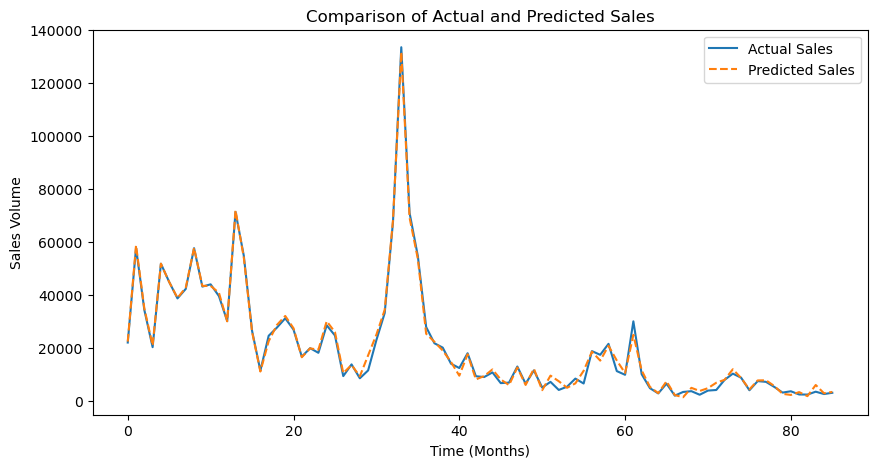

In [61]:
import matplotlib.pyplot as plt

# 预测并存储结果
predictions = []
targets = []

for dataset in dataloaders:
    X_train = dataset[0]
    y_train = dataset[1]
    hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))

    model.eval()  # 将模型设置为评估模式
    with torch.no_grad():
        pred_series = []
        for i in range(len(X_train)):
            x_input = X_train[i].view(1, 1, -1)  # 输入数据
            y_target = y_train[i].view(-1)  # 真实目标值
            y_pred, hidden = model(x_input, hidden)
            pred_series.append(y_pred.item())
    
    # 反归一化
    pred_series = scaler_y.inverse_transform(np.array(pred_series).reshape(-1, 1)).flatten()
    true_series = scaler_y.inverse_transform(y_train.numpy().reshape(-1, 1)).flatten()

    # 存储预测和目标数据
    predictions.extend(pred_series)
    targets.extend(true_series)

# 可视化
plt.figure(figsize=(10, 5))
plt.plot(targets, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', linestyle='--')
plt.title('Comparison of Actual and Predicted Sales')
plt.xlabel('Time (Months)')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()

In [9]:
df1_normalized['Int_month'] = df1['Month']
df1_normalized

,Month,Sales_volumn,Unit_price,Promotion_expense,ROI,Profit_rate,Unit_cost,Target,Version,Int_month
1,0.727273,0.050381,0.973270,0.131649,0.980080,0.989714,0.986858,0.152418,1.0,9
2,0.818182,0.152418,0.956766,0.358562,0.982591,0.991021,0.942107,0.424285,1.0,10
3,0.909091,0.424285,1.000000,1.000000,1.000000,1.000000,1.000000,0.246031,1.0,11
4,1.000000,0.246031,0.980296,0.578759,0.994776,0.997322,0.967248,0.139132,1.0,12
6,0.000000,0.139132,0.220385,0.137513,0.108295,0.191920,0.881458,0.378720,1.0,1
...,...,...,...,...,...,...,...,...,...,...
90,0.545455,0.003342,0.165537,0.000000,0.158389,0.269026,0.454225,0.003046,4.0,7
91,0.636364,0.003046,0.207884,0.001015,0.127762,0.222666,0.754672,0.011334,4.0,8
92,0.727273,0.011334,0.160170,0.007017,0.191483,0.316542,0.339362,0.004596,4.0,9
93,0.818182,0.004596,0.203774,0.002397,0.217092,0.351603,0.473498,0.008197,4.0,10


[0.90909091 0.00819672 0.22698795 0.00680365 0.35972465 0.5235162
 0.21846208]


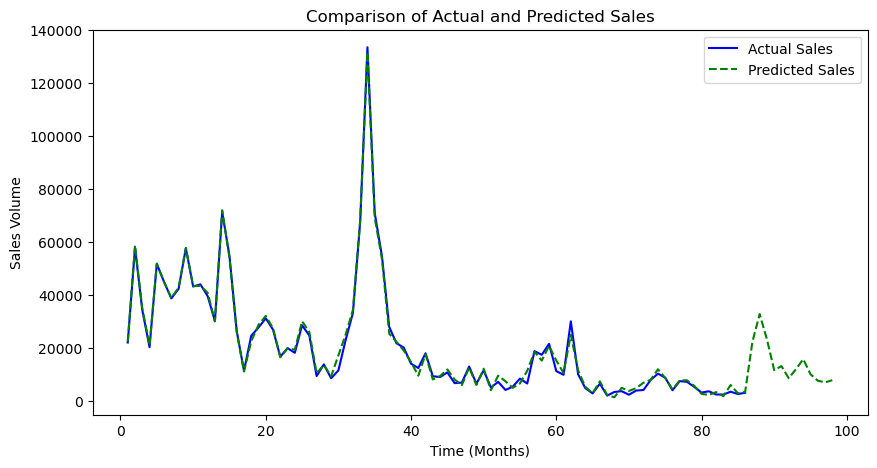

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# 假设 df_normalized 是包含所有归一化后数据的 DataFrame


# 计算每个月份的平均特征值
monthly_averages = df1_normalized.groupby('Int_month').mean()

# 初始化最后一个已知数据点，假设 month_index 是月份在特征中的索引位置
last_month_data = df1_normalized.iloc[-1, :].drop(['Target', 'Version', 'Int_month']).values
print(last_month_data)
input_features = last_month_data.reshape(1, 1, -1)
current_month = 11
future_predictions = []

sales_index = 1

for i in range(12):  # 预测未来12个月
    with torch.no_grad():
        # 模型预测
        model.eval()
        future_prediction, hidden = model(torch.tensor(input_features, dtype=torch.float32), hidden)
        predicted_sales = future_prediction.numpy().flatten()[0]
        
        # 反归一化预测值以获得实际的销量
        actual_sales = scaler_y.inverse_transform([[predicted_sales]])[0][0]
        future_predictions.append(actual_sales)
        
        # 计算下一个月份
        next_month = (current_month + 1)%12
        if next_month == 0:
            next_month = 12
        normalized_next_month  = (next_month - 1)/11
        input_features[0, 0, month_index] = normalized_next_month  # 重新归一化月份
        
        # 更新销量
        input_features[0, 0, sales_index] = predicted_sales
        
        # 更新其他特征为历史平均值
        for idx, feature in enumerate(features):
            if feature not in ['Month', 'Sales_volumn']:  # 假设月份和销量已处理
                input_features[0, 0, idx] = monthly_averages.loc[next_month, feature]

# 可视化未来一年的销量预测
# 合并过去拟合数据和未来预测数据
combined_predictions = predictions + future_predictions

# 生成时间轴
months_past = list(range(1, len(targets) + 1))  # 过去数据的月份
months_combined = list(range(1, len(targets) + len(future_predictions) + 1))  # 组合后的时间轴

# 开始绘图
plt.figure(figsize=(10, 5))

# 绘制实际数据
plt.plot(months_past, targets, label='Actual Sales', color='blue')
# 绘制拟合和未来预测数据
plt.plot(months_combined, combined_predictions, label='Predicted Sales', linestyle='--', color='green')

# 添加标题和轴标签
plt.title('Comparison of Actual and Predicted Sales')
plt.xlabel('Time (Months)')
plt.ylabel('Sales Volume')

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [13]:
#torch.save(model.state_dict(), 'pillow_sales_lstm_model.pth')

[0.90909091 0.00819672 0.22698795 0.00680365 0.35972465 0.5235162
 0.21846208]


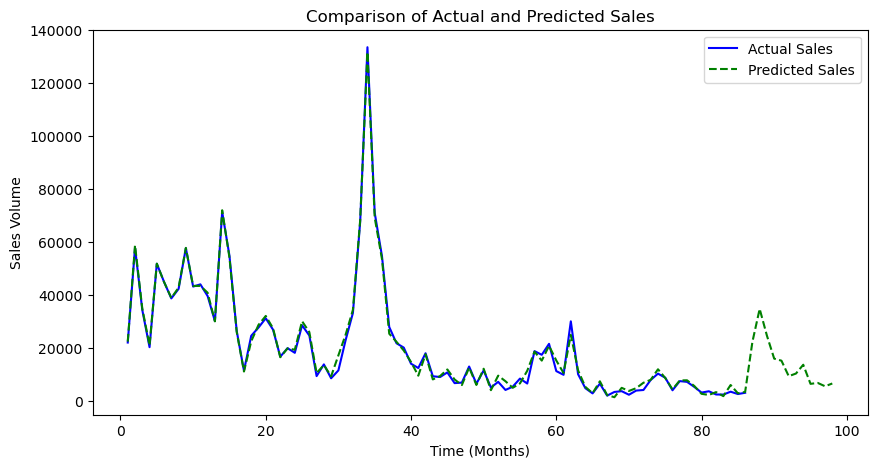

In [14]:
# 初始化最后一个已知数据点，假设 month_index 是月份在特征中的索引位置
last_month_data = df1_normalized.iloc[-1, :].drop(['Target', 'Version', 'Int_month']).values
print(last_month_data)
input_features = last_month_data.reshape(1, 1, -1)
current_month = 11
future_predictions2 = []

hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))
month_index = 0
sales_index = 1

for i in range(12):  # 预测未来12个月
    with torch.no_grad():
        # 模型预测
        model.eval()
        future_prediction, hidden = model(torch.tensor(input_features, dtype=torch.float32), hidden)
        predicted_sales = future_prediction.numpy().flatten()[0]
        
        # 反归一化预测值以获得实际的销量
        actual_sales = scaler_y.inverse_transform([[predicted_sales]])[0][0]
        future_predictions2.append(actual_sales)
        
        # 计算下一个月份
        next_month = (current_month + 1)%12
        if next_month == 0:
            next_month = 12
        normalized_next_month  = (next_month - 1)/11
        input_features[0, 0, month_index] = normalized_next_month  # 重新归一化月份
        
        # 更新销量
        input_features[0, 0, sales_index] = predicted_sales
        
        

# 可视化未来一年的销量预测
# 合并过去拟合数据和未来预测数据
combined_predictions2 = predictions + future_predictions2

# 生成时间轴
months_past = list(range(1, len(targets) + 1))  # 过去数据的月份
months_combined = list(range(1, len(targets) + len(future_predictions2) + 1))  # 组合后的时间轴

# 开始绘图
plt.figure(figsize=(10, 5))

# 绘制实际数据
plt.plot(months_past, targets, label='Actual Sales', color='blue')
# 绘制拟合和未来预测数据
plt.plot(months_combined, combined_predictions2, label='Predicted Sales', linestyle='--', color='green')

# 添加标题和轴标签
plt.title('Comparison of Actual and Predicted Sales')
plt.xlabel('Time (Months)')
plt.ylabel('Sales Volume')

# 添加图例
plt.legend()

# 显示图形
plt.show()

## 后续工作

1.参考周期，一个生命周期内的走势曲线
2.客户自定义策略，一组参数如何对一个周期的销量进行预测 
思路： 所谓的一组参数，可以认定为是这个周期内的特征均值，

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('./Dataset/latex_pillow.csv')
df1_normalized = pd.read_csv('./Dataset/latex_pillow_normalized.csv')

In [2]:
# 2. 定义 LSTM 模型
class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)
        predictions = self.fc(lstm_out)
        return predictions, hidden
# 参数设定
input_size = 7  # 特征数量
hidden_size = 50  # 隐藏层的大小，你可以调整
output_size = 1
num_epochs = 300
learning_rate = 0.01

model = SalesLSTM(input_size, hidden_size, output_size)
# 加载模型参数
model.load_state_dict(torch.load('pillow_sales_lstm_model.pth'))

# 设置模型为评估模式
model.eval()

SalesLSTM(
  (lstm): LSTM(7, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [6]:


# 假设 df_normalized 是包含所有归一化后数据的 DataFrame
# 计算每个月份的平均特征值
monthly_averages = df1_normalized.groupby('Int_month').mean()

# 初始化最后一个已知数据点，假设 month_index 是月份在特征中的索引位置
last_month_data = df1_normalized.iloc[-1, :].drop(['Target', 'Version', 'Int_month']).values
print(last_month_data)
input_features = last_month_data.reshape(1, 1, -1)
current_month = 11
future_predictions = []

hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))
month_index = 0
sales_index = 1

for i in range(12):  # 预测未来12个月
    with torch.no_grad():
        # 模型预测
        model.eval()
        future_prediction, hidden = model(torch.tensor(input_features, dtype=torch.float32), hidden)
        predicted_sales = future_prediction.numpy().flatten()[0]
        
        # 反归一化预测值以获得实际的销量
        actual_sales = scaler_y.inverse_transform([[predicted_sales]])[0][0]
        future_predictions.append(actual_sales)
        
        # 计算下一个月份
        next_month = (current_month + 1)%12
        if next_month == 0:
            next_month = 12
        normalized_next_month  = (next_month - 1)/11
        input_features[0, 0, month_index] = normalized_next_month  # 重新归一化月份
        
        # 更新销量
        input_features[0, 0, sales_index] = predicted_sales
        
        # 更新其他特征为历史平均值
        for idx, feature in enumerate(features):
            if feature not in ['Month', 'Sales_volumn']:  # 假设月份和销量已处理
                input_features[0, 0, idx] = monthly_averages.loc[next_month, feature]

# 可视化未来一年的销量预测
# 合并过去拟合数据和未来预测数据

targets = df1['Target'].to_list()
# 生成时间轴
months_past = list(range(1, len(targets) + 1))  # 过去数据的月份
months_future = list(range(len(targets) + 1, len(targets) + len(future_predictions) + 1))  # 组合后的时间轴

# 开始绘图
plt.figure(figsize=(10, 5))

# 绘制实际数据


plt.plot(months_past, targets, label='Actual Sales', color='blue')
# 绘制拟合和未来预测数据
plt.plot(months_future, future_predictions, label='Predicted Sales', linestyle='--', color='green')

# 添加标题和轴标签
plt.title('Comparison of Actual and Predicted Sales')
plt.xlabel('Time (Months)')
plt.ylabel('Sales Volume')

# 添加图例
plt.legend()

# 显示图形
plt.show()

[0.90909091 0.00819672 0.22698795 0.00680365 0.35972465 0.5235162
 0.21846208]


NameError: name 'scaler_y' is not defined

In [20]:
df_mean = df1.groupby('Month').mean()


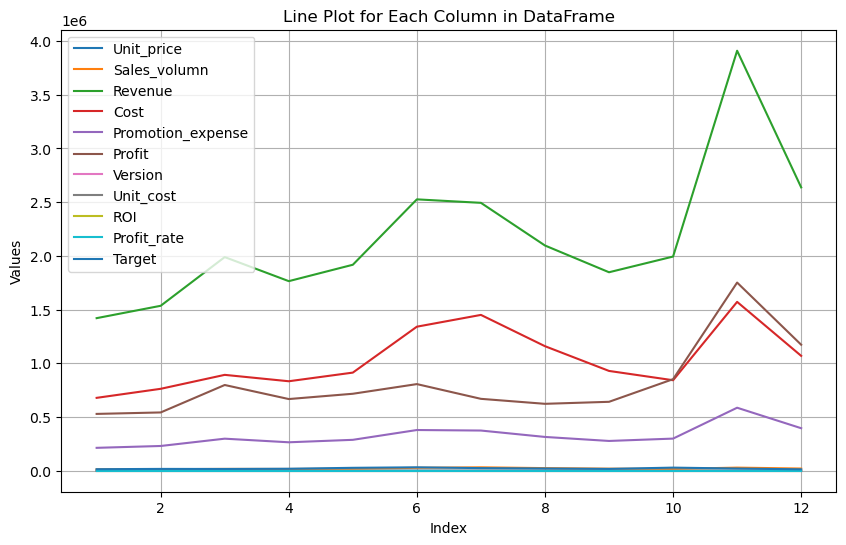

In [25]:
# 为每个列数据绘制曲线图
plt.figure(figsize=(10, 6))
for column in df_mean.columns:
    plt.plot(df_mean.index, df_mean[column], label=column)

plt.title('Line Plot for Each Column in DataFrame')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

按照均值进行完整周期的预测

[0.27272727 0.10911526 0.27286386 0.11507875 0.37080679 0.52064288
 0.38913294]


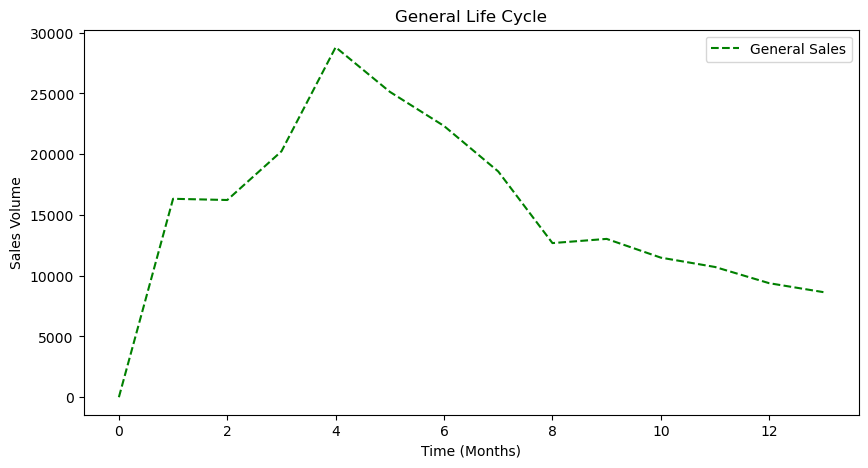

In [55]:
# 初始化最后一个已知数据点，假设 month_index 是月份在特征中的索引位置
first_month_data = df1_normalized[df1_normalized['Int_month'] == 4].mean().drop(['Target', 'Version', 'Int_month']).values
print(first_month_data)
input_features = first_month_data.reshape(1, 1, -1)
current_month = 4
future_predictions = [0]

hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))
month_index = 0
sales_index = 1

current_sales = df_mean.iloc[3, 1]
future_predictions.append(current_sales)

for i in range(12):  # 预测未来12个月
    with torch.no_grad():
        # 模型预测
        model.eval()
        future_prediction, hidden = model(torch.tensor(input_features, dtype=torch.float32), hidden)
        predicted_sales = future_prediction.numpy().flatten()[0]
        
        # 反归一化预测值以获得实际的销量
        actual_sales = scaler_y.inverse_transform([[predicted_sales]])[0][0]
        future_predictions.append(actual_sales)
        
        # 计算下一个月份
        next_month = (current_month + 1)%12
        if next_month == 0:
            next_month = 12
        normalized_next_month  = (next_month - 1)/11
        input_features[0, 0, month_index] = normalized_next_month  # 重新归一化月份
        
        # 更新销量
        input_features[0, 0, sales_index] = predicted_sales
        
        # 更新其他特征为历史平均值
        for idx, feature in enumerate(features):
            if feature not in ['Month', 'Sales_volumn']:  # 假设月份和销量已处理
                input_features[0, 0, idx] = monthly_averages.loc[next_month, feature]

# 可视化未来一年的销量预测
# 合并过去拟合数据和未来预测数据


# 开始绘图
plt.figure(figsize=(10, 5))

# 绘制实际数据

month = list(range(len(future_predictions)))

plt.plot(month, future_predictions, label='General Sales',linestyle='--', color='green')


# 添加标题和轴标签
plt.title('General Life Cycle')
plt.xlabel('Time (Months)')
plt.ylabel('Sales Volume')

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [51]:
df_mean, df_mean.describe()

(       Unit_price  Sales_volumn       Revenue          Cost  \
 Month                                                         
 1      109.238731  12922.000000  1.420124e+06  6.782913e+05   
 2      111.172844  14076.571429  1.535170e+06  7.624490e+05   
 3      119.452814  16857.142857  1.988501e+06  8.922827e+05   
 4      110.827034  16330.714286  1.764518e+06  8.327696e+05   
 5      103.970456  18387.142857  1.917145e+06  9.132443e+05   
 6      103.931045  27005.142857  2.525858e+06  1.340685e+06   
 7       97.469322  31752.857143  2.493431e+06  1.450332e+06   
 8       98.449958  24231.600000  2.096261e+06  1.159074e+06   
 9      113.085421  19095.375000  1.847354e+06  9.288165e+05   
 10     113.549565  16923.000000  1.993483e+06  8.422860e+05   
 11     117.328489  28813.375000  3.909338e+06  1.571564e+06   
 12     120.757744  20357.000000  2.637434e+06  1.069119e+06   
 
        Promotion_expense        Profit   Version  Unit_cost       ROI  \
 Month                      